In [1]:
import torch
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import soundfile as sf
import librosa
from librosa.display import specshow
import pandas as pd


from argparse import ArgumentParser
import random, sys, math, gzip, os
from tqdm import tqdm
import random, sys, math, gzip, os
import json
from tqdm import tqdm
from IPython.display import Audio 
import IPython
import soundfile 
import copy
import datetime

sys.path.append('../')
from dataloader.nsynthdataset import NSynthDataSet
from util import util
from transformer.transformers import GTransformer

%load_ext autoreload
%autoreload 2

np.seterr(divide='ignore', invalid='ignore')
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

In [2]:
config = util.get_config('../config/config-emb256.json')
data_dir = config['data_dir']
sample_rate = config['sample_rate']
batch_size = config['batch_size']
lr = config['lr']
lr_warmup = config['lr_warmup']
epochs = config['epochs']

sample_length = config['sample_length']
embedding_size = config['embedding_size'] 
num_heads = config['num_heads']
depth = config['depth']
num_tokens = config['num_tokens']

lower_pitch_limit = config['lower_pitch_limit']
upper_pitch_limit = config['upper_pitch_limit']

In [3]:
model_interp = GTransformer(emb=embedding_size, heads=num_heads, depth=depth, seq_length=sample_length, num_tokens=num_tokens, attention_type=None)
model_interp = model_interp.cuda()

opt_interp = torch.optim.Adam(lr=lr, params=model_interp.parameters())
sch_interp = torch.optim.lr_scheduler.LambdaLR(opt_interp, lambda i: min(i / (lr_warmup / batch_size), 1.0))
loss_interp = torch.nn.NLLLoss(reduction='mean')

In [4]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model_interp)

3257088

In [5]:
print(model_interp)

GTransformer(
  (token_embedding): Linear(in_features=4, out_features=256, bias=True)
  (token_embedding_batchnorm): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (token_embedding_activation): ReLU()
  (pos_embedding): Linear(in_features=128, out_features=256, bias=True)
  (pos_embedding_batchnorm): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (pos_embedding_activation): ReLU()
  (tblocks): Sequential(
    (0): TransformerBlock(
      (attention): SelfAttention(
        (tokeys): Linear(in_features=256, out_features=256, bias=False)
        (toqueries): Linear(in_features=256, out_features=256, bias=False)
        (tovalues): Linear(in_features=256, out_features=256, bias=False)
        (unifyheads): Linear(in_features=256, out_features=256, bias=True)
      )
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (ff): Se

In [6]:
def load_model(model, opt, model_location):
    checkpoint = torch.load(model_location)
    model.load_state_dict(checkpoint['model_state_dict'])
    opt.load_state_dict(checkpoint['optimizer_state_dict'])
    loss = checkpoint['loss']
    epoch = checkpoint['epoch']
    return model, opt, loss, epoch

def mulawEncodeInput(inputd):
    inputd = (librosa.mu_compress(inputd, quantize=False) + 1)/2
    return inputd

def mulawDecodeInput(output):
    output = (output * 2) - 1
    waveform = librosa.mu_expand(output, quantize=False)
    return waveform

def mulawEncodeTarget(inputd):
    target = librosa.mu_compress(inputd, quantize=True) + 127
    target = target.astype(np.long)
    return target

def mulawDecodeTarget(output):
    output = output - 127
    waveform = librosa.mu_expand(output, quantize=True)
    return waveform

def get_scaled_pitch(pitch):
    return (pitch - lower_pitch_limit)/(upper_pitch_limit - lower_pitch_limit)

In [7]:
def get_data(idx, start_location):
    input_data = np.array([])
    audio_data = np.array([])
    
    print(idx)
    if idx == 'random':
        input_data = np.random.rand((sample_length)) * 0.1
        audio_data = input_data
        target = np.random.rand((sample_length))
    else:
        start_location = int(start_location * 16000)

        audio_file_name = os.path.join(data_dir, idx+'.wav')
        audio_data, _ = librosa.load(audio_file_name, sr=sample_rate)
        input_data = audio_data[start_location:start_location + sample_length]
        target = audio_data[start_location + 1:start_location + 1 + sample_length]

        
    IPython.display.display(IPython.display.Audio(audio_data, rate=sample_rate))
    
    fig, axes = plt.subplots(ncols=2, figsize=(8,4))
    axes[0].plot(audio_data)
    axes[0].set(title='Sample Length = 64000/4 secs')
    axes[1].plot(input_data)
    axes[1].set(title='Sample Length = 512/32 ms')
    
    plt.show()
    
    return input_data, target

In [8]:
model_interp, opt_interp, loss_interp, epoch_interp = load_model(model_interp, opt_interp, '../checkpoint-emb256/models/40000.pt')
print('Model Loaded -> ', epoch_interp, loss_interp)

Model Loaded ->  40000 NLLLoss()


In [9]:
def model_stability_test(seed_id, model_interp, start_location=1.0, pitch=64, \
                                           amplitude_scale=0.9, instrument_id=0, seq_len=1024, \
                                           threshold='50'):
    seed, seed_target = get_data(seed_id, start_location)
    
    start_time = datetime.datetime.now().replace(microsecond=0)
    orig_waveform = copy.copy(seed)

    input_data = mulawEncodeInput(copy.copy(seed))
    final_sample_data = torch.from_numpy(copy.copy(input_data)).view(1, -1).cuda()
    input_pitch = np.broadcast_to(np.array([get_scaled_pitch(pitch)]), input_data.shape)
    scale = np.broadcast_to(np.array([amplitude_scale]), input_data.shape)
    instrument = np.broadcast_to(np.array([instrument_id]), input_data.shape)
    input_data = np.stack((input_pitch, scale, instrument, input_data), axis=1)
    input_data = torch.from_numpy(input_data).cuda()
    
    
    new_pitch = pitch
    
    model_interp.eval()
    
    # 1. Sample from model
    with torch.no_grad():
        for ind in range(seq_len):
            input_data = input_data.view(1, -1, 4).float() #Convert to batch_size X seq_len X 2
            sample_data = model_interp(input_data) #Output is batch_size X seq_length X one_hot len (256) i.e. 1 X 512 X 256. 
            
            sample_data = sample_data[0, -1, :].argmax() #Get the last sample probabilities and argmax.
            
            sample_data = mulawDecodeTarget(sample_data.view(1,-1).cpu().numpy())
            sample_data = (librosa.mu_compress(sample_data, quantize=False) + 1)/2 #Just like what we do in NSynthDataSet_RawAudio.py
            sample_data = torch.from_numpy(sample_data).view(1,-1).cuda()
            
            final_sample_data = torch.cat((final_sample_data, sample_data), dim=1)
            if ind < threshold:
                input_data = torch.from_numpy(mulawEncodeInput(copy.copy(seed)).reshape(1,-1)).cuda()
            else:
                input_data = final_sample_data[:,final_sample_data.shape[1]-sample_length:].view(1,-1)
            
            input_data = torch.cat((torch.from_numpy(input_pitch).view(1,-1).cuda(),\
                                    torch.from_numpy(scale).view(1, -1).cuda(),\
                                    torch.from_numpy(instrument).view(1, -1).cuda(),\
                                    input_data), dim=0)
            input_data = input_data.T
            
    
    final_sample_data = final_sample_data.view(-1).cpu().numpy()
    waveform = mulawDecodeInput(final_sample_data)
    
    # 2. Audio
    IPython.display.display(IPython.display.Audio(orig_waveform, rate=sample_rate))
    IPython.display.display(IPython.display.Audio(waveform, rate=sample_rate))
    
    # 3. Plot waveforms
    fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
    axes[0].plot(orig_waveform)
    axes[0].set_title('Original Seed')

    axes[1].plot(waveform)
    axes[1].set_title('New Sample')
    plt.show()
    
    # 4. Plot spectrograms
    fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
    gs = gridspec.GridSpec(2,1)
    
    D = librosa.stft(orig_waveform, n_fft=512)  # STFT of y
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    img = librosa.display.specshow(S_db, x_axis='time', y_axis='log', ax=axes[0])
    axes[0].set(title='Orig seed')
#     fig.colorbar(img, ax=axes[0], format="%+2.f dB")
    
    D = librosa.stft(waveform, hop_length=390)  # STFT of y
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    img = librosa.display.specshow(S_db, x_axis='time', y_axis='log', ax=axes[1])
    axes[1].set(title='New Sample')
#     fig.colorbar(img, ax=axes[1], format="%+2.f dB")
    plt.show()
    
    
    # 4. Plot spectrograms
    fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
    gs = gridspec.GridSpec(2,1)
    
    D = librosa.stft(orig_waveform, n_fft=512)  # STFT of y
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    img = librosa.display.specshow(S_db, x_axis='time', y_axis='linear', ax=axes[0])
    axes[0].set(title='Orig seed')
#     fig.colorbar(img, ax=axes[0], format="%+2.f dB")
    
    D = librosa.stft(waveform, hop_length=390)  # STFT of y
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    img = librosa.display.specshow(S_db, x_axis='time', y_axis='linear', ax=axes[1])
    axes[1].set(title='New Sample')
#     fig.colorbar(img, ax=axes[1], format="%+2.f dB")
    plt.show()
    print('Time taken for sampling/plotting = ', datetime.datetime.now().replace(microsecond=0) - start_time)
    return waveform, orig_waveform

reed_acoustic_000-064-a.0


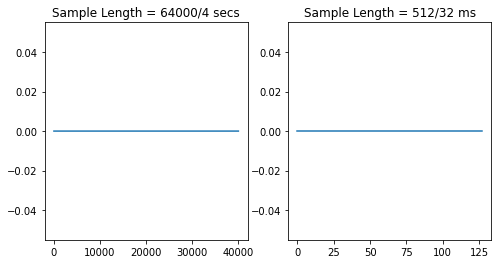

<ipython-input-9-884db127c416>:40: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:137.)
  input_data = torch.cat((torch.from_numpy(input_pitch).view(1,-1).cuda(),\


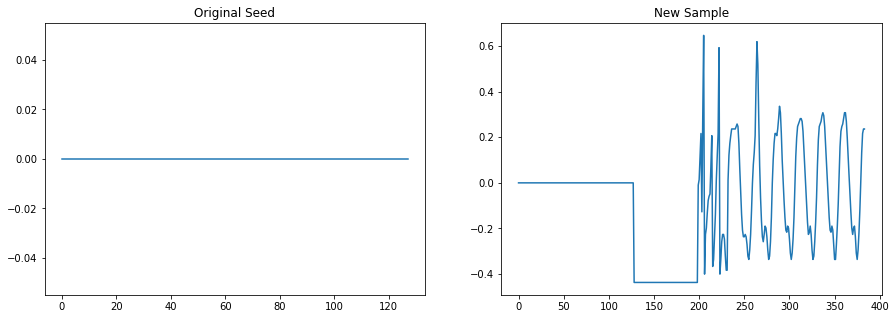

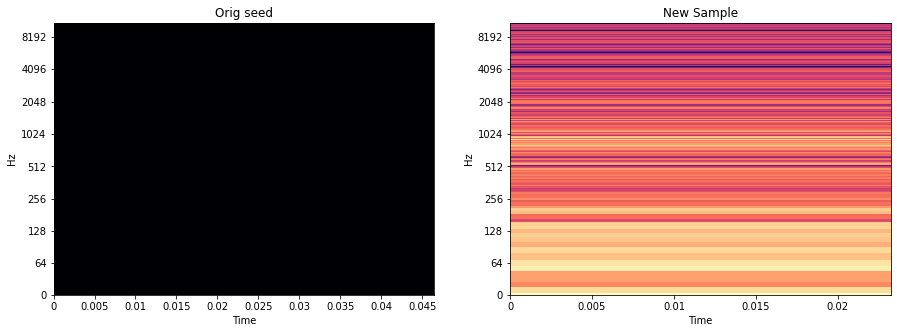

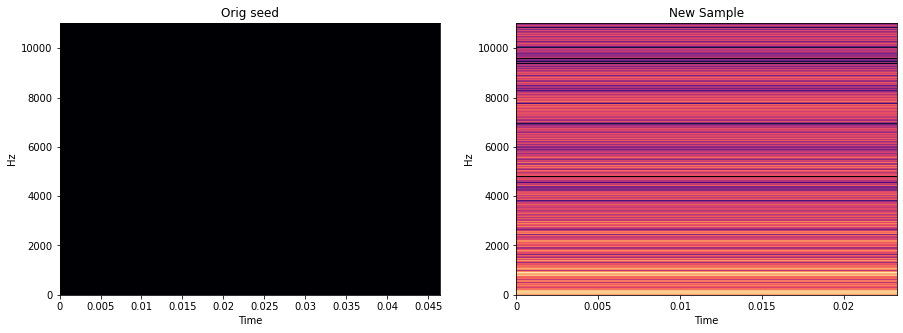

Time taken for sampling/plotting =  0:00:02


In [10]:
new_sample, orig_seed = model_stability_test('reed_acoustic_000-064-a.0', model_interp=model_interp, start_location=1, pitch=76, amplitude_scale=0.9, \
                                     instrument_id=1, seq_len=256, threshold=70)

random


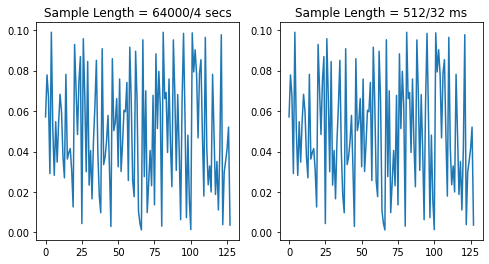

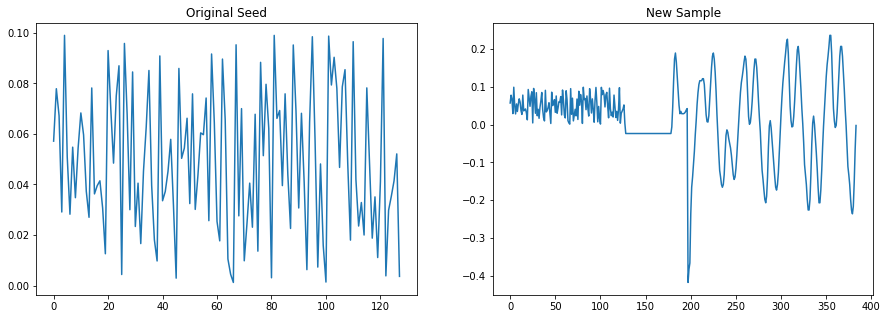

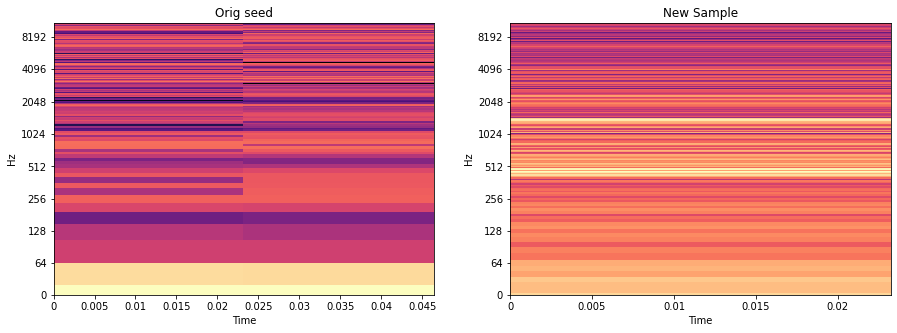

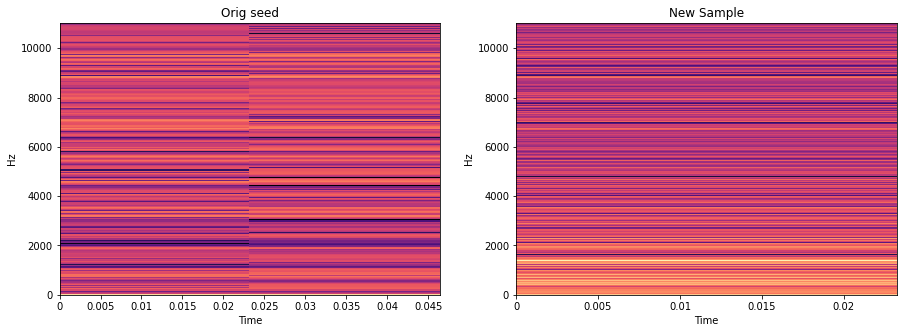

Time taken for sampling/plotting =  0:00:02


In [11]:
new_sample, orig_seed = model_stability_test('random', model_interp=model_interp, start_location=1, pitch=64, amplitude_scale=0.9, \
                                     instrument_id=1, seq_len=256, threshold=50)